In [1]:
# Import dependencies
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import scipy.stats as st

In [2]:
# Read into excel file
xls = pd.ExcelFile("./Resources/KPMG_VI_New_raw_data_update_final.xlsx")
transactions_xls = pd.read_excel(xls, "Transactions", header=1)
new_customer_list_xls = pd.read_excel(xls, "NewCustomerList", header=1)
customer_demographic_xls = pd.read_excel(xls, "CustomerDemographic", header=1)
customer_address_xls = pd.read_excel(xls, "CustomerAddress", header=1)

## Data Cleaning

In [3]:
# Create function to drop all customer_ids above 3500
def consistent_id(excel_sheet):
    excel_sheet = excel_sheet.loc[excel_sheet["customer_id"] <= 3500]
    return excel_sheet

In [4]:
# Apply range of below 3500 to all sheets
cleaned_transactions_xls = consistent_id(transactions_xls)
cleaned_customer_demographic_xls = consistent_id(customer_demographic_xls)
cleaned_customer_address_xls = consistent_id(customer_address_xls)

### Transactions

In [5]:
cleaned_transactions_xls

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,51,1018,2017-06-24,1.0,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,37823.0
19996,19997,41,127,2017-11-09,1.0,Approved,Solex,Road,medium,medium,416.98,312.74,35560.0
19997,19998,87,2284,2017-04-14,1.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,40410.0
19998,19999,6,2764,2017-07-03,0.0,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,38216.0


In [6]:
# Convert online order column to boolean
cleaned_transactions_xls["online_order"] = cleaned_transactions_xls["online_order"].astype(bool)

In [7]:
# Drop all null values for transactions
cleaned_transactions_xls = cleaned_transactions_xls.dropna()

In [8]:
# Display cleaned dataframe
cleaned_transactions_xls.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


### Customer Demographics

In [9]:
# Drop null values only for DOB and job title columns of customer demographics
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls.dropna(subset=["DOB", "job_title"])

In [10]:
# Drop default column of meta data
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls.drop(columns="default")

In [11]:
# Check remaining null values
# Remain nulls for last_name and job_industry_category as they do not affect future analysis
cleaned_customer_demographic_xls.count()

customer_id                            3004
first_name                             3004
last_name                              2908
gender                                 3004
past_3_years_bike_related_purchases    3004
DOB                                    3004
job_title                              3004
job_industry_category                  2531
wealth_segment                         3004
deceased_indicator                     3004
owns_car                               3004
tenure                                 3004
dtype: int64

In [12]:
# Find outlier of DOB column
cleaned_customer_demographic_xls["DOB"].min()

Timestamp('1843-12-21 00:00:00')

In [13]:
# Drop outlier
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls[cleaned_customer_demographic_xls.DOB != "1843-12-21 00:00:00"]

In [14]:
# Add age column
now = pd.Timestamp("now")
cleaned_customer_demographic_xls["age"] = (now - cleaned_customer_demographic_xls["DOB"]).astype("<m8[Y]")

In [15]:
# Create age bins for analysis later
cleaned_customer_demographic_xls["age_bins"] = pd.cut(x=cleaned_customer_demographic_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89])

In [16]:
cleaned_customer_demographic_xls["age_bins"].unique()

[(59, 69], (29, 39], (39, 49], (49, 59], (19, 29], (10, 19], (69, 79], (79, 89]]
Categories (8, interval[int64]): [(10, 19] < (19, 29] < (29, 39] < (39, 49] < (49, 59] < (59, 69] < (69, 79] < (79, 89]]

In [17]:
cleaned_customer_demographic_xls["age_by_decade"] = pd.cut(x=cleaned_customer_demographic_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89], labels=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s"])

In [18]:
# Check for gender unique values
cleaned_customer_demographic_xls["gender"].value_counts()

Female    1532
Male      1468
Femal        1
M            1
F            1
Name: gender, dtype: int64

In [19]:
# Replace inconsistent values in gender column
cleaned_customer_demographic_xls["gender"] = cleaned_customer_demographic_xls["gender"].replace(["Femal", "F", "M"], ["Female", "Female", "Male"])

In [20]:
# List all available columns
cd_cols = list(cleaned_customer_demographic_xls.columns.values)
cd_cols

['customer_id',
 'first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure',
 'age',
 'age_bins',
 'age_by_decade']

In [21]:
# Rearrange columns
cleaned_customer_demographic_xls = cleaned_customer_demographic_xls
[['customer_id',
 'first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'age',
 'age_bins',
 'age_by_decade',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure']]

[['customer_id',
  'first_name',
  'last_name',
  'gender',
  'past_3_years_bike_related_purchases',
  'DOB',
  'age',
  'age_bins',
  'age_by_decade',
  'job_title',
  'job_industry_category',
  'wealth_segment',
  'deceased_indicator',
  'owns_car',
  'tenure']]

In [22]:
# Display cleaned dataframe
cleaned_customer_demographic_xls.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,age,age_bins,age_by_decade
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,67.0,"(59, 69]",60s
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,39.0,"(29, 39]",30s
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,66.0,"(59, 69]",60s
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,43.0,"(39, 49]",40s
7,8,Rod,Inder,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,No,7.0,58.0,"(49, 59]",50s


### Customer Address

In [23]:
# Check for null values
cleaned_customer_address_xls.count()

customer_id           3496
address               3496
postcode              3496
state                 3496
country               3496
property_valuation    3496
dtype: int64

In [24]:
# Check for values that need to be replaced
cleaned_customer_address_xls["state"].value_counts()

NSW                1783
VIC                 801
QLD                 744
New South Wales      86
Victoria             82
Name: state, dtype: int64

In [25]:
# Replace inconsistent values in state column
cleaned_customer_address_xls["state"] = cleaned_customer_address_xls["state"].replace(["New South Wales", "Victoria"], ["NSW", "VIC"])

In [26]:
# Check if values were successfully replaced
cleaned_customer_address_xls["state"].value_counts()

NSW    1869
VIC     883
QLD     744
Name: state, dtype: int64

In [27]:
# Display cleaned dataframe
cleaned_customer_address_xls.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,NSW,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


### New customer list

In [28]:
# Add age column to new customers list
new_customer_list_xls["age"] = (now - new_customer_list_xls["DOB"]).astype("<m8[Y]")

In [29]:
# Create age bins for analysis later
new_customer_list_xls["age_bins"] = pd.cut(x=new_customer_list_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89])

In [30]:
# Create age bins labels
new_customer_list_xls["age_by_decade"] = pd.cut(x=new_customer_list_xls['age'], bins=[10, 19, 29, 39, 49, 59, 69, 79, 89], labels=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s"])

In [31]:
# List all available columns in dataframe
cl_cols = list(new_customer_list_xls.columns.values)
cl_cols

['first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure',
 'address',
 'postcode',
 'state',
 'country',
 'property_valuation',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19',
 'Unnamed: 20',
 'Rank',
 'Value',
 'age',
 'age_bins',
 'age_by_decade']

In [32]:
# Rearrange columns
new_customer_list_xls = new_customer_list_xls[['first_name',
 'last_name',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'age',
 'age_bins',
 'age_by_decade',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'tenure',
 'address',
 'postcode',
 'state',
 'country',
 'property_valuation',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19',
 'Unnamed: 20',
 'Rank',
 'Value']]

In [33]:
# Display final dataframe
new_customer_list_xls.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,age,age_bins,age_by_decade,job_title,job_industry_category,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,63.0,"(59, 69]",60s,General Manager,Manufacturing,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,50.0,"(49, 59]",50s,Structural Engineer,Property,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,46.0,"(39, 49]",40s,Senior Cost Accountant,Financial Services,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,41.0,"(39, 49]",40s,Account Representative III,Manufacturing,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,55.0,"(49, 59]",50s,Financial Analyst,Financial Services,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


## Exploratory Data Analysis

In [34]:
# Merge customer demographics and transactions dataframes
merged_transactions_demographics = pd.merge(cleaned_customer_demographic_xls, cleaned_transactions_xls, on="customer_id", how="inner")
merged_transactions_demographics

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-12-23,False,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38482.0
1,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-04-06,True,Approved,Solex,Standard,medium,medium,1577.53,826.51,39526.0
2,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-05-11,True,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
3,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-01-05,False,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,37873.0
4,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2017-02-21,False,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17023,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,N,...,2017-03-07,False,Approved,Trek Bicycles,Mountain,low,medium,574.64,459.71,37659.0
17024,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,N,...,2017-04-02,True,Approved,Norco Bicycles,Standard,high,small,1661.92,1479.11,40303.0
17025,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,N,...,2017-11-08,True,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,42688.0
17026,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,N,...,2017-09-01,True,Approved,Solex,Standard,medium,medium,575.27,431.45,35160.0


In [35]:
merged_transactions_demographics.count()

customer_id                            17028
first_name                             17028
last_name                              16490
gender                                 17028
past_3_years_bike_related_purchases    17028
DOB                                    17028
job_title                              17028
job_industry_category                  14315
wealth_segment                         17028
deceased_indicator                     17028
owns_car                               17028
tenure                                 17028
age                                    17028
age_bins                               17028
age_by_decade                          17028
transaction_id                         17028
product_id                             17028
transaction_date                       17028
online_order                           17028
order_status                           17028
brand                                  17028
product_line                           17028
product_cl

In [36]:
# Merge customer address and transactions dataframes
merged_transactions_address = pd.merge(cleaned_customer_address_xls, merged_transactions_demographics, on="customer_id", how="inner")
merged_transactions_address

,customer_id,address,postcode,state,country,property_valuation,first_name,last_name,gender,past_3_years_bike_related_purchases,...,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-12-23,False,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38482.0
1,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-04-06,True,Approved,Solex,Standard,medium,medium,1577.53,826.51,39526.0
2,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-05-11,True,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
3,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-01-05,False,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,37873.0
4,1,060 Morning Avenue,2016,NSW,Australia,10,Laraine,Medendorp,Female,93,...,2017-02-21,False,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17010,3496,2565 Caliangt Point,2171,NSW,Australia,9,Danya,Burnyeat,Male,99,...,2017-03-07,False,Approved,Trek Bicycles,Mountain,low,medium,574.64,459.71,37659.0
17011,3496,2565 Caliangt Point,2171,NSW,Australia,9,Danya,Burnyeat,Male,99,...,2017-04-02,True,Approved,Norco Bicycles,Standard,high,small,1661.92,1479.11,40303.0
17012,3497,96 Delladonna Trail,3976,VIC,Australia,5,Thia,O'Day,Female,73,...,2017-11-08,True,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,42688.0
17013,3497,96 Delladonna Trail,3976,VIC,Australia,5,Thia,O'Day,Female,73,...,2017-09-01,True,Approved,Solex,Standard,medium,medium,575.27,431.45,35160.0


In [37]:
merged_transactions_address.count()

customer_id                            17015
address                                17015
postcode                               17015
state                                  17015
country                                17015
property_valuation                     17015
first_name                             17015
last_name                              16477
gender                                 17015
past_3_years_bike_related_purchases    17015
DOB                                    17015
job_title                              17015
job_industry_category                  14302
wealth_segment                         17015
deceased_indicator                     17015
owns_car                               17015
tenure                                 17015
age                                    17015
age_bins                               17015
age_by_decade                          17015
transaction_id                         17015
product_id                             17015
transactio

## Customer Segmentation Analysis
### Finding potential relationships between variables - use Seaborn heatmap
### Exploring demographic, geographic, behavioural, psychographic data

age vs past 3 years bike related purchases

gender vs past 3 years bike related purchases

state vs cars owned - bar chart

wealth segment by age  - stacked bar chart

state vs owns cars - grouped bar chart

In [38]:
# Use seaborn styling for charts
plt.style.use("seaborn")

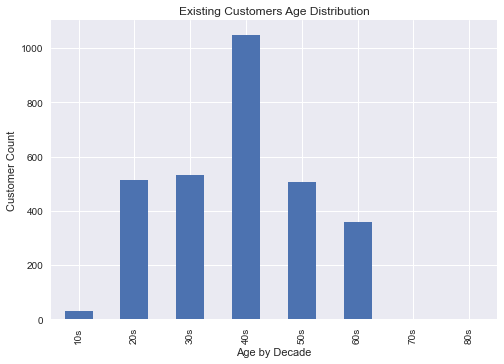

In [39]:
# Existing customers age distribution
grouped_age = merged_transactions_demographics.groupby(["age_by_decade"])
people_count = grouped_age["customer_id"].nunique()
people_count.plot.bar()
plt.style.use("seaborn")
plt.title("Existing Customers Age Distribution")
plt.xlabel("Age by Decade")
plt.ylabel("Customer Count")
plt.savefig("output/existing_customers_age_distribution.png")

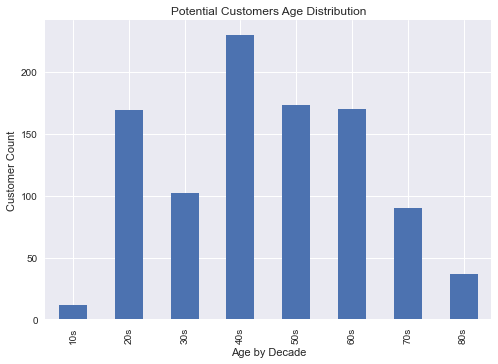

In [40]:
# Potential customers age distribution
grouped_age = new_customer_list_xls.groupby(["age_by_decade"])
people_count = grouped_age["first_name"].count()
people_count.plot.bar()
plt.title("Potential Customers Age Distribution")
plt.xlabel("Age by Decade")
plt.ylabel("Customer Count")
plt.savefig("output/potential_customers_age_distribution.png")

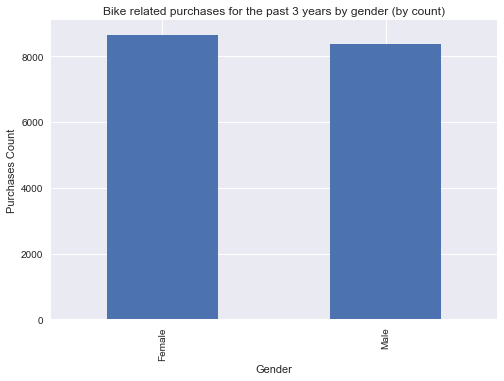

In [41]:
# Bike related purchases for the past 3 years by gender (existing customers)
grouped_gender = merged_transactions_demographics.groupby("gender")
three_years_transactions_count = grouped_gender.past_3_years_bike_related_purchases.count()
three_years_transactions_count.plot.bar(title="Bike related purchases for the past 3 years by gender (by count)")
plt.xlabel("Gender")
plt.ylabel("Purchases Count")
plt.savefig("output/bike_related_purchases_last_3_years_by_gender.png")

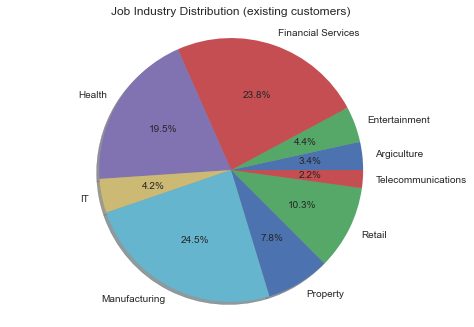

In [42]:
# Job Industry Distribution
grouped_job_categories = merged_transactions_address.groupby(["job_industry_category"])
job_category_count = grouped_job_categories["customer_id"].count()
job_category_count.plot.pie(title="Job Industry Distribution (existing customers)", autopct='%1.1f%%', shadow=True)
plt.ylabel("")
plt.axis("equal")
plt.savefig("output/job_industry_distribution_existing_customers.png")

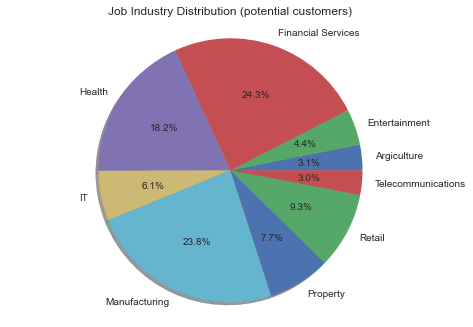

In [43]:
# Job Industry Distribution
grouped_job_categories = new_customer_list_xls.groupby(["job_industry_category"])
job_category_count = grouped_job_categories["first_name"].count()
job_category_count.plot.pie(title="Job Industry Distribution (potential customers)", autopct='%1.1f%%', shadow=True)
plt.ylabel("")
plt.axis("equal")
plt.savefig("output/job_industry_distribution_potential_customers.png")

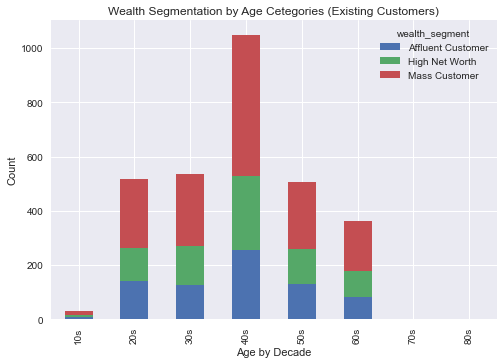

In [44]:
# Wealth segmentation by age category - stacked bar chart (existing customers)
grouped_age = cleaned_customer_demographic_xls.groupby(["age_by_decade"])
wealth_segment = grouped_age["wealth_segment"].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title("Wealth Segmentation by Age Cetegories (Existing Customers)")
plt.xlabel("Age by Decade")
plt.ylabel("Count")
plt.savefig("output/wealth_segmentation_by_age_existing_customers.png")

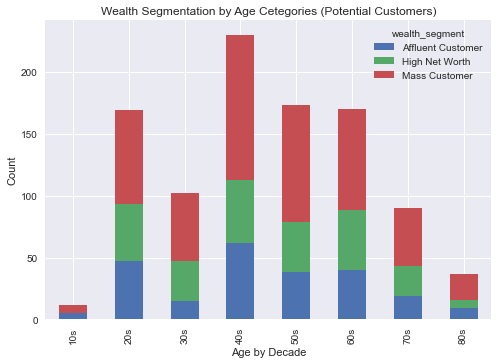

In [45]:
# Wealth segmentation by age category - stacked bar chart (potential customers)
grouped_age = new_customer_list_xls.groupby(["age_by_decade"])
wealth_segment = grouped_age["wealth_segment"].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title("Wealth Segmentation by Age Cetegories (Potential Customers)")
plt.xlabel("Age by Decade")
plt.ylabel("Count")
plt.savefig("output/wealth_segmentation_by_age_potential_customers.png")

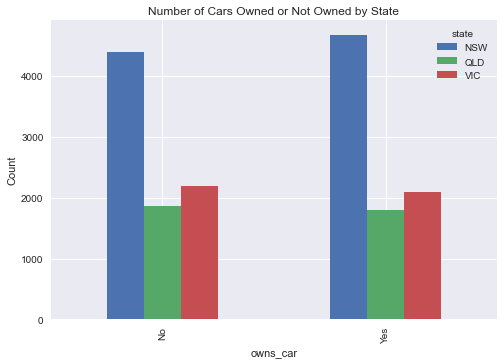

In [46]:
# Number of cars owned or not owned by state - grouped bar chart
merged_transactions_address.groupby("state").owns_car.value_counts().unstack(0).plot.bar()
plt.title("Number of Cars Owned or Not Owned by State")
plt.ylabel("Count")
plt.savefig("output/number_of_cars_owned_or_not_owned_by_state.png")

## Model Development
### Customer Segmentation using RFM analysis
Steps of RFM(Recency, Frequency, Monetary):

1. Calculate the Recency, Frequency, Monetary values for each Customer

2. Add segment bin values to RFM table using quartile

3. Sort the customer RFM score in ascending order

Correlation

In [47]:
cleaned_transactions_xls

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,51,1018,2017-06-24,True,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,37823.0
19996,19997,41,127,2017-11-09,True,Approved,Solex,Road,medium,medium,416.98,312.74,35560.0
19997,19998,87,2284,2017-04-14,True,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,40410.0
19998,19999,6,2764,2017-07-03,False,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,38216.0


In [48]:
# Define present date
latest_date = cleaned_transactions_xls["transaction_date"].max()
print(latest_date)

present = dt.datetime(2017,12,31)
present

2017-12-30 00:00:00


datetime.datetime(2017, 12, 31, 0, 0)

In [49]:
cleaned_transactions_xls["transaction_date"] = pd.to_datetime(cleaned_transactions_xls["transaction_date"])

In [50]:
# Calculate Recency, Frequency and Monetary
rfm = cleaned_transactions_xls.groupby("customer_id").agg({"transaction_date": lambda date: (present - date.max()).days, 
                                                            "transaction_id": lambda num: len(num),
                                                            "list_price": lambda price: price.sum()})
rfm.columns

Index(['transaction_date', 'transaction_id', 'list_price'], dtype='object')

In [51]:
# Change column names
rfm.columns=["recency","frequency","monetary"]
rfm["recency"] = rfm["recency"].astype(int)
rfm

,recency,frequency,monetary
customer_id,,,
1,8,11,9084.45
2,129,3,4149.07
3,103,8,9888.23
4,196,2,1047.72
5,17,6,5903.20
...,...,...,...
3496,257,4,4725.38
3497,53,3,3744.07
3498,128,6,5177.06


### Computing Quantile of RFM values
Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [52]:
# Using qcut() to bin data based on sample quantiles
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['4','3','2','1'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['1','2','3','4'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['1','2','3','4'])
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
customer_id,,,,,,
1,8,11,9084.45,4,4,4
2,129,3,4149.07,1,1,1
3,103,8,9888.23,1,4,4
4,196,2,1047.72,1,1,1
5,17,6,5903.20,4,2,2
...,...,...,...,...,...,...
3496,257,4,4725.38,1,1,2
3497,53,3,3744.07,2,1,1
3498,128,6,5177.06,1,2,2


### RFM Result Interpretation
Combine all three quartiles(r_quartile,f_quartile,m_quartile) in a single column, this rank will help to segment the customers well group.

In [53]:
rfm["RFM_Score"] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
1,8,11,9084.45,4,4,4,444
2,129,3,4149.07,1,1,1,111
3,103,8,9888.23,1,4,4,144
4,196,2,1047.72,1,1,1,111
5,17,6,5903.20,4,2,2,422
...,...,...,...,...,...,...,...
3496,257,4,4725.38,1,1,2,112
3497,53,3,3744.07,2,1,1,211
3498,128,6,5177.06,1,2,2,122


In [54]:
# Filter out Top/Best customers
rfm[rfm["RFM_Score"]=="444"].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
2183,9,14,19071.32,4,4,4,444
1140,7,13,16199.24,4,4,4,444
729,2,10,15826.00,4,4,4,444
1317,11,9,15370.81,4,4,4,444
1329,5,11,14818.12,4,4,4,444


Generating Unique Customer Segments based on RFM Score

### 1.Core - Your Best Customers

RFM Score: 444

Who They Are: Highly engaged customers who have bought the most recent, the most often, and generated the most revenue.

### 2.Loyal - Your Most Loyal Customers

RFM Score: X4X

Who They Are: Customers who buy the most often from your store.

### 3.Whales - Your Highest Paying Customers

RFM Score: XX4

Who They Are: Customers who have generated the most revenue for your store.

### 4.Becoming Loyal - Customers With Good Impression On The Company

RFM Score: 42X

Who They Are: Customers who are becoming loyal by recently purchases and with promising frequency.

### 5.Rookies - Your Newest Customers

RFM Score: 41X

Who They Are: First time buyers on your site.

### 6.Slipping - Once Loyal, Now Gone

RFM Score: 11X

Who They Are: Great past customers who haven't bought in awhile.

### 7.Regular - The customers having common behaviour across these metrics.

RFM Score: Remaining Scores

Who They Are: Customer who have average metrics across each RFM scores.

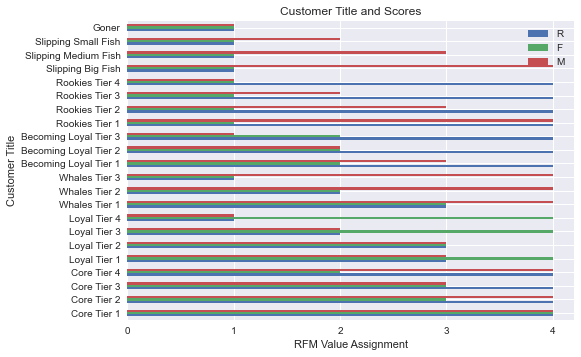

In [75]:
# Define customer titles and their respective rfm scores
customer_titles = dict([
    ("Core Tier 1", [4, 4, 4]),
    ("Core Tier 2", [4, 3, 4]),
    ("Core Tier 3", [4, 3, 3]),
    ("Core Tier 4", [4, 2, 4]),
    ("Loyal Tier 1", [3, 4, 3]),
    ("Loyal Tier 2", [3, 3, 3]),
    ("Loyal Tier 3", [2, 4, 2]),
    ("Loyal Tier 4", [1, 4, 1]),
    ("Whales Tier 1", [3, 3, 4]),
    ("Whales Tier 2", [2, 2, 4]),
    ("Whales Tier 3", [1, 1, 4]),
    ("Becoming Loyal Tier 1", [4, 2, 3]),
    ("Becoming Loyal Tier 2", [4, 2, 2]),
    ("Becoming Loyal Tier 3", [4, 2, 1]),
    ("Rookies Tier 1", [4, 1, 4]),
    ("Rookies Tier 2", [4, 1, 3]),
    ("Rookies Tier 3", [4, 1, 2]),
    ("Rookies Tier 4", [4, 1, 1]),
    ("Slipping Big Fish", [1, 1, 4]),
    ("Slipping Medium Fish", [1, 1, 3]),
    ("Slipping Small Fish", [1, 1, 2]),
    ("Goner", [1, 1, 1])
])

# Convert to dataframe
# .T transposes letter categories to the x-axis
customer_titles_df = pd.DataFrame(customer_titles).T

# Visualise
customer_titles_df.plot(kind="barh")
plt.title("Customer Title and Scores")
plt.xlabel("RFM Value Assignment")
plt.ylabel("Customer Title")
plt.legend(["R", "F", "M"])
xticks=[0, 1, 2, 3, 4]
plt.xticks(np.arange(5), xticks)
plt.savefig("output/customer_title_and_scores.png")

In [58]:
# Create a function to plot linear regression
def create_linear_regression_plot(x_values, y_values, x_label, y_label, line_placement, ylim=None):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    
    # Using pyplot to create scatter plot
    plt.scatter(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if ylim != None:
        plt.ylim = (0, ylim)
    plt.title(f'{x_label} vs. {y_label}')
    plt.annotate(line_eq,line_placement,fontsize=15,color="red")
    
    # Print r-squared value
    print(f"The r-squared is: {rvalue**2}")
    
    # Print correlation between both factors
    correlation = st.pearsonr(x_values,y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")

    # Tight layout
    plt.tight_layout()
    
    # Save linear regression plot as png file
    plt.savefig(f"output/{x_label}_vs_{y_label}.png")
    
    return plt.plot(x_values,regress_values,"r-")

The r-squared is: 0.10428799549112847
The correlation between both factors is -0.32


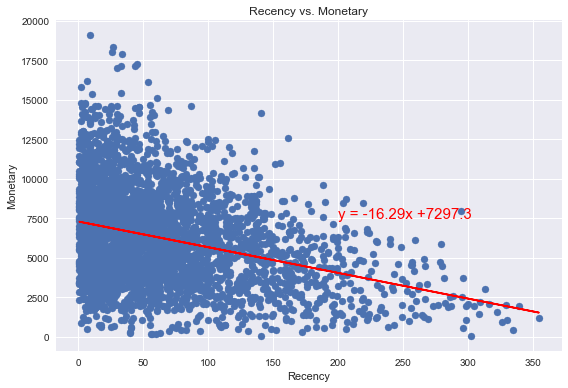

In [59]:
# Visualise recency vs monetary
x_values = rfm.recency
y_values = rfm.monetary

create_linear_regression_plot(x_values, y_values, "Recency", "Monetary", (200, 7500), ylim=None)

The r-squared is: 0.754365951232456
The correlation between both factors is 0.87


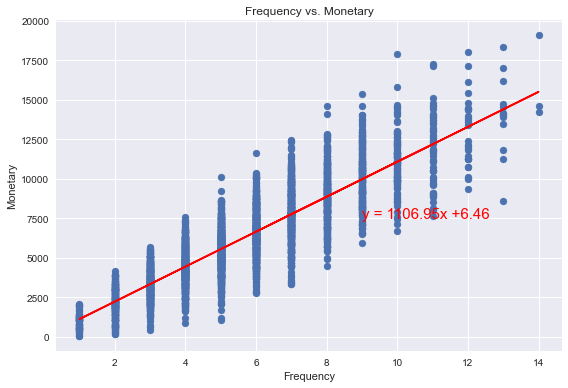

In [60]:
# Visualise frequency vs monetary
x_values = rfm.frequency
y_values = rfm.monetary

create_linear_regression_plot(x_values, y_values, "Frequency", "Monetary", (9, 7500), ylim=None)

The r-squared is: 0.1432063088537255
The correlation between both factors is -0.38


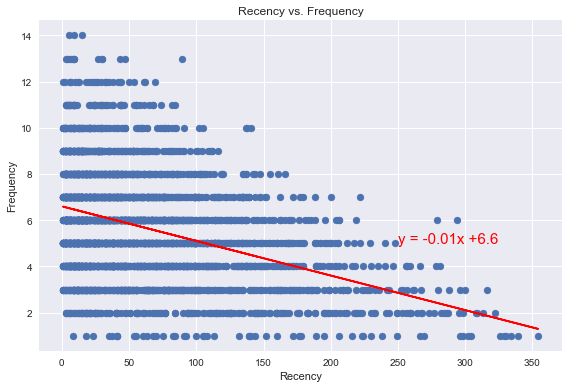

In [61]:
# Visualise recency vs monetary
x_values = rfm.recency
y_values = rfm.frequency

create_linear_regression_plot(x_values, y_values, "Recency", "Frequency", (250, 5), ylim=None)

In [76]:
customer_titles = dict([
    ("Core Tier 1", [4, 4, 4]),
    ("Core Tier 2", [4, 3, 4]),
    ("Core Tier 3", [4, 3, 3]),
    ("Core Tier 4", [4, 2, 4]),
    ("Loyal Tier 1", [3, 4, 3]),
    ("Loyal Tier 2", [3, 3, 3]),
    ("Loyal Tier 3", [2, 4, 2]),
    ("Loyal Tier 4", [1, 4, 1]),
    ("Whales Tier 1", [3, 3, 4]),
    ("Whales Tier 2", [2, 2, 4]),
    ("Whales Tier 3", [1, 1, 4]),
    ("Becoming Loyal Tier 1", [4, 2, 3]),
    ("Becoming Loyal Tier 2", [4, 2, 2]),
    ("Becoming Loyal Tier 3", [4, 2, 1]),
    ("Rookies Tier 1", [4, 1, 4]),
    ("Rookies Tier 2", [4, 1, 3]),
    ("Rookies Tier 3", [4, 1, 2]),
    ("Rookies Tier 4", [4, 1, 1]),
    ("Slipping Big Fish", [1, 1, 4]),
    ("Slipping Medium Fish", [1, 1, 3]),
    ("Slipping Small Fish", [1, 1, 2]),
    ("Goner", [1, 1, 1])
])

In [77]:
# Create function to segment customers into unique titles based on their rfm scores
def customer_segment(row):
    if row["RFM_Score"] == "444":
        return "Core Tier 1"
    elif row["RFM_Score"] == "434":
        return "Core Tier 2"
    elif row["RFM_Score"] == "433":
        return "Core Tier 3"
    elif row["RFM_Score"] == "424":
        return "Core Tier 4"
    elif row["RFM_Score"] == "343":
        return "Loyal Tier 1"
    elif row["RFM_Score"] == "333":
        return "Loyal Tier 2"
    elif row["RFM_Score"] == "242":
        return "Loyal Tier 3"
    elif row["RFM_Score"] == "141":
        return "Loyal Tier 4"
    elif row["RFM_Score"] == "334":
        return "Whales Tier 1"
    elif row["RFM_Score"] == "224":
        return "Whales Tier 2"
    elif row["RFM_Score"] == "114":
        return "Whales Tier 3"
    elif row["RFM_Score"] == "423":
        return "Becoming Loyal Tier 1"
    elif row["RFM_Score"] == "422":
        return "Becoming Loyal Tier 2"
    elif row["RFM_Score"] == "421":
        return "Becoming Loyal Tier 3"
    elif row["RFM_Score"] == "414":
        return "Rookies Tier 1"
    elif row["RFM_Score"] == "413":
        return "Rookies Tier 2"
    elif row["RFM_Score"] == "412":
        return "Rookies Tier 3"
    elif row["RFM_Score"] == "411":
        return "Rookies Tier 4"
    elif row["RFM_Score"] == "114":
        return "Slipping Big Fish"
    elif row["RFM_Score"] == "113":
        return "Slipping Medium Fish"
    elif row["RFM_Score"] == "112":
        return "Slipping Small Fish"
    elif row["RFM_Score"] == "111":
        return "Goner"
    else:
        return "Regular"

In [78]:
# Apply function to each customer's rfm scores
rfm["segment_name"] = rfm.apply(lambda row: customer_segment(row), axis=1)

In [79]:
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score,segment_name
customer_id,,,,,,,,
1,8,11,9084.45,4,4,4,444,Core Tier 1
2,129,3,4149.07,1,1,1,111,Goner
3,103,8,9888.23,1,4,4,144,Regular
4,196,2,1047.72,1,1,1,111,Goner
5,17,6,5903.20,4,2,2,422,Becoming Loyal Tier 2
...,...,...,...,...,...,...,...,...
3496,257,4,4725.38,1,1,2,112,Slipping Small Fish
3497,53,3,3744.07,2,1,1,211,Regular
3498,128,6,5177.06,1,2,2,122,Regular


In [80]:
rfm["segment_name"].value_counts()

Regular                  2019
Goner                     335
Core Tier 1               210
Becoming Loyal Tier 1     126
Slipping Small Fish       119
Rookies Tier 4            114
Becoming Loyal Tier 2     113
Loyal Tier 2               69
Rookies Tier 3             69
Core Tier 3                59
Core Tier 2                52
Whales Tier 1              50
Loyal Tier 1               42
Whales Tier 2              27
Becoming Loyal Tier 3      26
Core Tier 4                25
Slipping Medium Fish       18
Rookies Tier 2             17
Loyal Tier 3                3
Name: segment_name, dtype: int64

In [90]:
# Customer segmentation summary statistics
grouped_rfm = rfm.groupby("segment_name")
rfm_summary_stats = grouped_rfm.describe()
rfm_summary_stats

recency                                              \
                        count        mean        std   min     25%    50%   
segment_name                                                                
Becoming Loyal Tier 1   126.0    9.753968   5.328694   1.0    5.00   11.0   
Becoming Loyal Tier 2   113.0    9.362832   5.293294   1.0    4.00   10.0   
Becoming Loyal Tier 3    26.0    8.038462   5.820521   1.0    3.00    7.5   
Core Tier 1             210.0    8.647619   4.961056   1.0    4.25    8.0   
Core Tier 2              52.0    8.865385   5.273050   1.0    4.00    9.0   
Core Tier 3              59.0    9.593220   5.058685   1.0    6.00   10.0   
Core Tier 4              25.0    8.520000   5.561175   1.0    4.00    7.0   
Goner                   335.0  165.800000  62.286704  88.0  115.00  152.0   
Loyal Tier 1             42.0   32.571429   8.202150  19.0   27.25   33.0   
Loyal Tier 2             69.0   31.797101   8.035912  19.0   24.00   32.0   
Loyal Tier 3              3.0   69.000000  19.974984  47.0   60.50   74.0   
Regular                2019.0   63.068846  39.929655   1.0   33.00   55.0   
Rookies Tier 2           17.0    9.764706   5.651653   2.0    4.00   10.0   
Rookies Tier 3           69.0    9.884058   4.986854   1.0    6.00   10.0   
Rookies Tier 4          114.0   10.500000   4.910257   1.0    7.00   11.0   
Slipping Medium Fish     18.0  137.166667  52.112153  88.0  100.50  128.5   
Slipping Small Fish     119.0  150.016807  49.101932  88.0  109.00  143.0   
Whales Tier 1            50.0   32.860000   7.816806  19.0   26.00   32.5   
Whales Tier 2            27.0   62.000000  14.602423  46.0   49.00   56.0   

                                     frequency            ...              \
                          75%    max     count      mean  ...   75%   max   
segment_name                                              ...               
Becoming Loyal Tier 1   14.00   18.0     126.0  5.650794  ...   6.0   6.0   
Becoming Loyal Tier 2   14.00   18.0     113.0  5.380531  ...   6.0   6.0   
Becoming Loyal Tier 3   11.75   18.0      26.0  5.307692  ...   6.0   6.0   
Core Tier 1             13.00   18.0     210.0  9.414286  ...  10.0  14.0   
Core Tier 2             13.25   18.0      52.0  7.000000  ...   7.0   7.0   
Core Tier 3             14.00   18.0      59.0  7.000000  ...   7.0   7.0   
Core Tier 4             13.00   18.0      25.0  5.880000  ...   6.0   6.0   
Goner                  202.00  354.0     335.0  2.600000  ...   3.0   4.0   
Loyal Tier 1            39.00   45.0      42.0  8.309524  ...   8.0  11.0   
Loyal Tier 2            39.00   45.0      69.0  7.000000  ...   7.0   7.0   
Loyal Tier 3            80.00   86.0       3.0  8.000000  ...   8.0   8.0   
Regular                 80.00  294.0    2019.0  5.944032  ...   7.0  13.0   
Rookies Tier 2          15.00   18.0      17.0  4.000000  ...   4.0   4.0   
Rookies Tier 3          14.00   18.0      69.0  3.826087  ...   4.0   4.0   
Rookies Tier 4          14.00   18.0     114.0  3.149123  ...   4.0   4.0   
Slipping Medium Fish   141.50  259.0      18.0  4.000000  ...   4.0   4.0   
Slipping Small Fish    173.00  280.0     119.0  3.697479  ...   4.0   4.0   
Whales Tier 1           41.00   45.0      50.0  7.000000  ...   7.0   7.0   
Whales Tier 2           76.50   84.0      27.0  5.925926  ...   6.0   6.0   

                      monetary                                                 \
                         count          mean          std      min        25%   
segment_name                                                                    
Becoming Loyal Tier 1    126.0   6953.261825   593.373732  5999.72  6455.0450   
Becoming Loyal Tier 2    113.0   5181.330531   541.136226  4196.26  4728.1300   
Becoming Loyal Tier 3     26.0   3444.731538   660.253003  1718.19  2952.2300   
Core Tier 1              210.0  10938.030952  1893.384597  8161.56  9403.9550   
Core Tier 2               52.0   9467.762115  1011.231153  8157.7

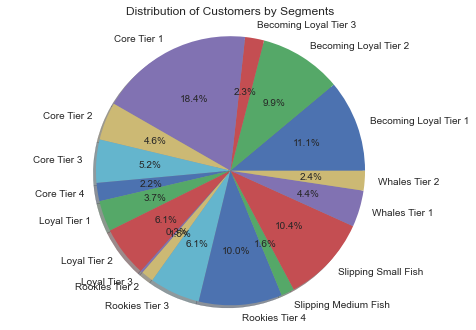

In [99]:
# Visualise customer segmentation
# Remove regular customer segment for more meaningful vis
reduced_rfm = rfm.loc[(rfm["segment_name"] != "Regular") & (rfm["segment_name"] != "Goner")]

# Groupby reduced rfm df
grouped_reduced_rfm = reduced_rfm.groupby("segment_name")
customer_distribution = grouped_reduced_rfm["segment_name"].count()

# Plot
customer_distribution.plot.pie(title="Distribution of Customers by Segments", autopct='%1.1f%%', shadow=True)
plt.ylabel("")
plt.axis("equal")
plt.savefig("output/customer_disctibution_by_unique_segments.png")